In [49]:

import numpy as np
import pandas as pd
import shap 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier, plot_importance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost.callback import EarlyStopping

import warnings
warnings.filterwarnings('ignore')



In [50]:
df = pd.read_csv('Data/titanic.csv')
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
df = pd.get_dummies(df)


In [51]:
target = 'Survived'
y = df[target]

X = df.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
model = XGBClassifier(
    n_estimators=10000,
    max_depth=5,
    learning_rate = 0.1,
    reg_lambda=0.1,
    subsample = 0.5,
    col_sample_by_tree = 0.8,
    tree_method='hist'
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100)


[0]	validation_0-logloss:0.61223	validation_1-logloss:0.63728


[100]	validation_0-logloss:0.21399	validation_1-logloss:0.43380
[200]	validation_0-logloss:0.15503	validation_1-logloss:0.46494
[300]	validation_0-logloss:0.12462	validation_1-logloss:0.49907
[400]	validation_0-logloss:0.10727	validation_1-logloss:0.53620
[500]	validation_0-logloss:0.09491	validation_1-logloss:0.54877
[600]	validation_0-logloss:0.08772	validation_1-logloss:0.56103
[700]	validation_0-logloss:0.08238	validation_1-logloss:0.56915
[800]	validation_0-logloss:0.07763	validation_1-logloss:0.58425
[900]	validation_0-logloss:0.07402	validation_1-logloss:0.59773
[1000]	validation_0-logloss:0.07082	validation_1-logloss:0.60711
[1100]	validation_0-logloss:0.06890	validation_1-logloss:0.63391
[1200]	validation_0-logloss:0.06620	validation_1-logloss:0.62561
[1300]	validation_0-logloss:0.06516	validation_1-logloss:0.64662
[1400]	validation_0-logloss:0.06331	validation_1-logloss:0.64723
[1500]	validation_0-logloss:0.06218	validation_1-logloss:0.64979
[1600]	validation_0-logloss:0.0613

XGBClassifier(base_score=None, booster=None, callbacks=None,
              col_sample_by_tree=0.8, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10000, n_jobs=None, ...)

In [53]:
best_model = model
probabilidades = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_score= probabilidades, y_true=y_test)
auc_score

0.8585585585585584

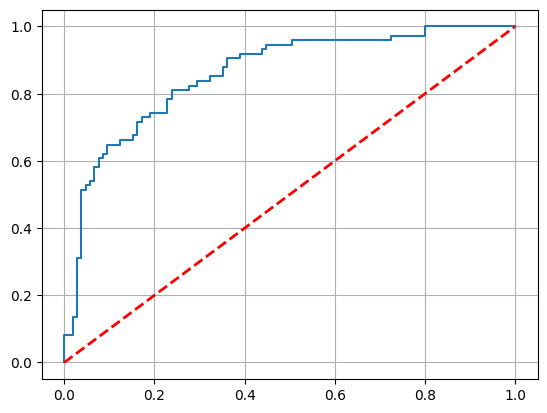

In [54]:
fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

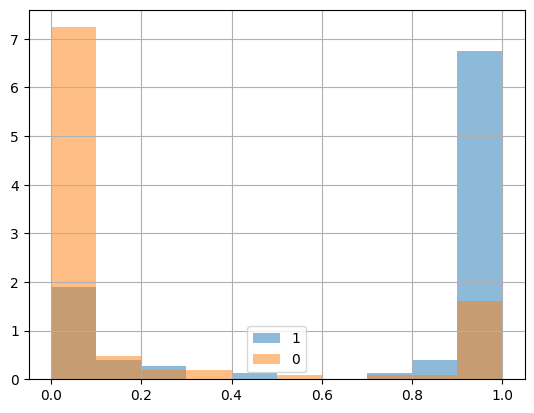

In [55]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

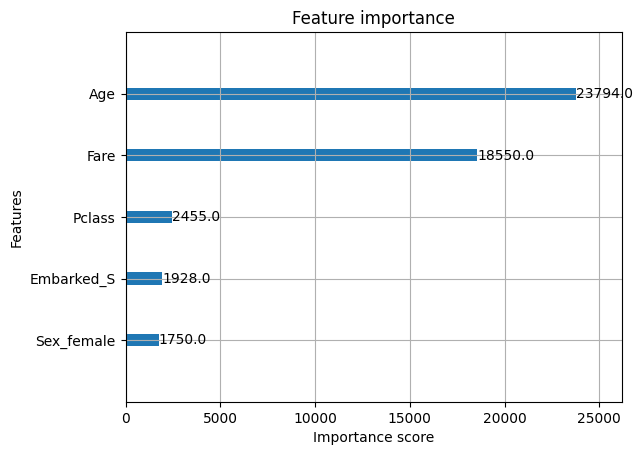

In [56]:
plot_importance(model, max_num_features=5, importance_type='weight')

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

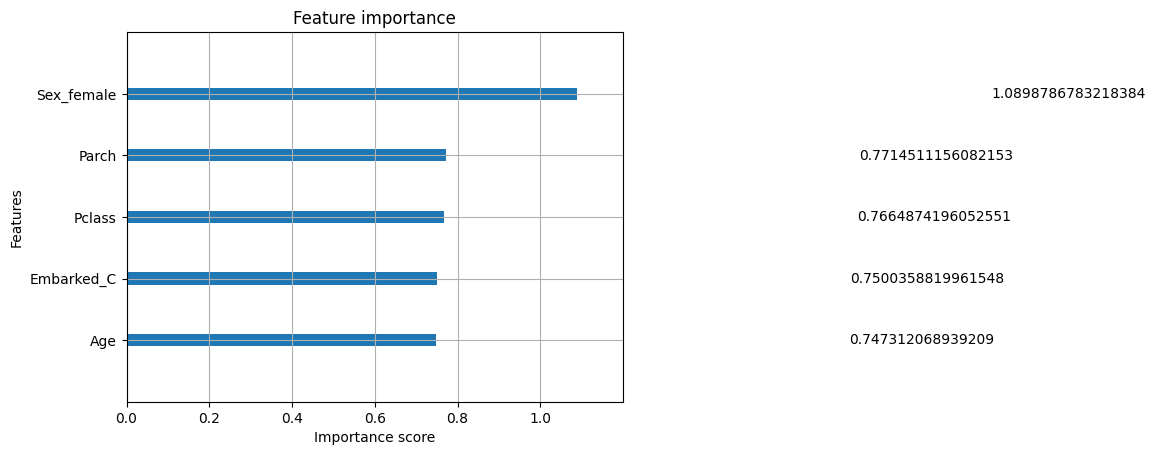

In [57]:
plot_importance(model, max_num_features=5, importance_type='gain')

Aplicando XGBoost notamos que se obtuvo un AUC de 0.8585, al ver las feature importances del modelo en weight podemos ver que las dos variables que más se utilizaron fueron edad y fare, mientras que en el tipo gain la que más ayudo a reducir el error del modelo cada vez que se usaba era que el sexo de la persona sea mujer.

In [ ]:
X_shap = X_test.sample(100, random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)



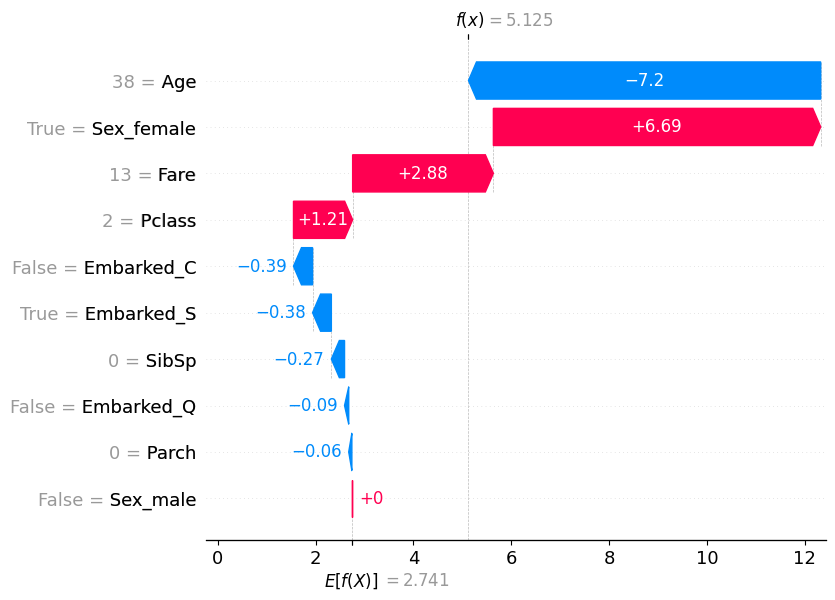

In [66]:
shap.initjs()
# Para visualizar shap individual con waterfall plot
# input: shap.Explanation(values=shaps[0])
shap.waterfall_plot(shap.Explanation(values=shap_values[0],
                    base_values = explainer.expected_value,
                    data=X_shap.iloc[0],
                    feature_names= X_shap.keys()))

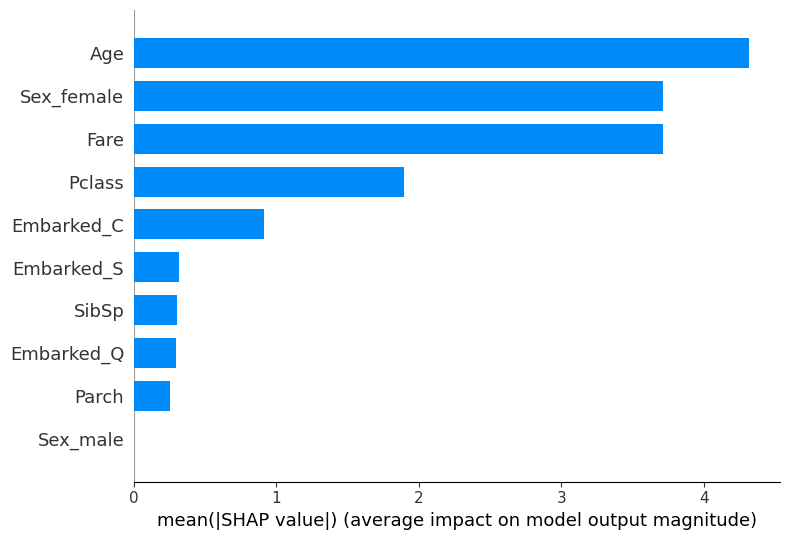

In [67]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")

Analizando el gráfico de barras podemos ver que las variables que más impactaron al modelo son edad, sex_female y fare, para la predicción de que una persona del titanic sobreviva

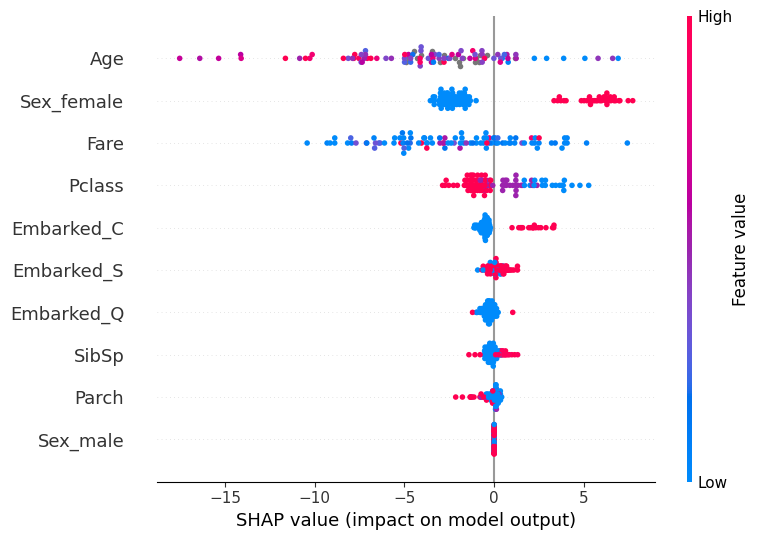

In [60]:
shap.summary_plot(shap_values, X_shap, plot_type="dot")

Al ver el dot plot notamos que igual que con el gráfico de barras las variables edad, sex_female y fare son significativas, sobre todo podemos ver en la variable de sex_female que cuando es mujer tiene un valor alto en la predicción, igual aunque esta mucho más mezclada en la edad podemos ver que aunque no se puede apreciar tanto, el mayor numero de valores altos o puntos rojos se encuentran en edades menores y los puntos azules o de menor valor se encuentran en edades más altas.

Text(0, 0.5, 'Inertia')

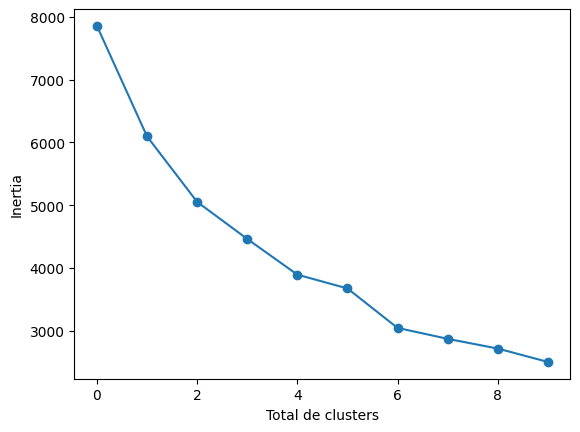

In [61]:
df = df.copy().dropna()

inertias = []

K_range = range(1, 11)
for i in K_range:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=i, random_state=42))
    ])
    pipeline.fit(df)
    inertias.append(pipeline.named_steps['kmeans'].inertia_)

plt.plot(inertias, marker='o')
plt.xlabel('Total de clusters')
plt.ylabel('Inertia')

El numero de clusters optimos es de 3 ya que al observar la gráfica podemos notar que en este número es donde se encuentra el codo, se podrían utilizar más clusters pero la disminución de error del modelo no sería tan significativa.

In [62]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])
pipeline.fit(df)
df['cluster'] = pipeline.predict(df)

df.groupby('cluster').mean()


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
cluster,,,,,,,,,,,
0,0.179688,2.424479,30.318359,0.463542,0.260417,21.745809,0.000000,1.000000,0.0,0.041667,0.958333
1,0.710000,2.195000,27.785000,0.665000,0.770000,37.714563,1.000000,0.000000,0.0,0.060000,0.930000
2,0.607692,1.746154,30.814769,0.423077,0.415385,68.296767,0.469231,0.530769,1.0,0.000000,0.000000


Viendo cluster por cluster podemos ver que, el cluster 1 71% de las personas sobrevivieron, mientras que en el 0 podemos ver que solo el 17% lo hicieron, esto se debe más que nada a que en el cluster 1 el 100% de los pasajeros eran mujeres y en el 0 el 100% hombres, lo cual hace sentido comparandolo con el SHAP, en el cluster 2 podemos ver que tiene un 60%, conformado por 46% de mujeres y 53% de hombres. Otro punto interesante es el de la tarifa, en el cluster 0 donde se tomaron 100% hombres tambien notamos que su tarifa es la más baja y la más alta la del cluster 2, donde podemos ver que existe una mezcla entre hombres y mujeres pero es donde se encuentra la gente con la tarifa más alta.
 
Se puede ver que la edad promedio de los 3 clusters se acerca a 30 años, pero incluso notamos que el cluster con menor promedio es el de las mujeres.

In [63]:
df.groupby('cluster').sum()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
cluster,,,,,,,,,,,
0,69,931,11642.25,178,100,8350.3907,0,384,0,16,368
1,142,439,5557.00,133,154,7542.9126,200,0,0,12,186
2,79,227,4005.92,55,54,8878.5797,61,69,130,0,0


El cluster en el que más personas sobrevivieron es el 1 donde se encuentran solamente mujeres y donde sobrevivieron menos fue los del cluster 0, siendo el cluster que contenía solamente hombre, haciendo sentido a esta dinamica que existio donde se le daba prioridad a las mujeres, niños y a la gente con dinero.